In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from tqdm.notebook import tqdm

import cv2
## augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim

import numpy as np, pandas as pd, gc
import cv2, matplotlib.pyplot as plt

# ## Rapid
# import cudf, cuml, cupy
# from cuml.feature_extraction.text import TfidfVectorizer
# from cuml.neighbors import NearestNeighbors


import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# print('RAPIDS',cuml.__version__)
print('TF',tf.__version__)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TF 1.15.0


## Dataset Visualization

In [6]:
train = pd.read_csv('../../../shopee-product-matching/train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [7]:
len(train), len(train.image.unique()), len(train.image_phash.unique())

(34250, 32412, 28735)

In [42]:
def plt_image(path):
    img = cv2.imread(path)
    plt.axis('off')
    plt.imshow(img[:,:,::-1])
    h,w = img.shape[:2]
#     plt.title(f'{w} x {h}')

0: 1KG BISA 7PCS | GEYSA PANTS / CELANA STRADI / CELANA SALUR SELEBGRAM
1: 832P - FLEXIBLE Sambungan Kran FLEXIBLE irit air Keran Splash shower--168--
2: Set Piyama Sexy dengan Celana Pendek
3: Petis Boyya Surabaya
4: BAJ JAM TANGAN APPLE WATCH IPHONE RUBBER IMPORT TOUCH SCREEN LED DIGITAL PRIA WANITA GROSIR
5: Pantene Conditioner 3 Minutes Miracle Quantum Total Damage Care 180 ml [P&G]
6: FS Beras Setra Wangi Premium 5kg
7: PAKET KACAMATA FASHION + LENSA PHOTOCHROMIC / BLUERAY
8: Acnoc Acneser Spot Gel 15g
9: Pengait Sprei Karet Jepitan Pengencang Sudut Sprei Sheet Gripper R23
10: FOOMEE headset QA06 wired headset stereo sound
11: Maybelline Fit Me! Liquid Concealer MakeUp - 10 Light (Dengan Coverage Tinggi & Hasil Natural)
12: DISPENSER SABUN 2 TABUNG 2 IN 1/DISPENSER SABUN KOTAK SENTUH UNIK
13: CLB / GB GLOW EMBOS KEMASAN BARU ORIGINAL
14: Wardah Everyday Fruity Sheer Lip Balm Strawberry 4g
15: Headset / Handsfree U19 macaron / Macaroon Mate Color Hifi Extra Bass
16: STROLLER LABEIL

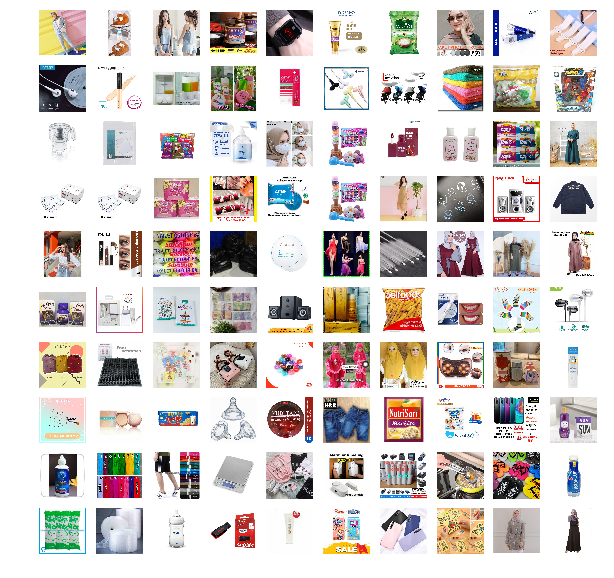

In [45]:
## Example of dataset image
plt.figure(figsize=(10,10))
for i,p  in enumerate(range(120, 120+100)):
    plt.subplot(10,10,i+1)
    img_path = train.image[p]
    img_path = "../../../shopee-product-matching/train_images/" + img_path
    plt_image(img_path)
    print(f"{i}: {train.title[p]}" )

In [38]:
grp = train.groupby('label_group', as_index=True).agg(
    counts=("image",'count'), 
    images=("image", list),
    titles=("title", list)
)
grp = grp.sort_values('counts', ascending=False)
print("Total Group", len(grp['counts']))
grp.head()

Total Group 11014


,counts,images,titles
label_group,,,
1163569239,51,"[089060edc61ec626e6b4943cf18dd651.jpg, 0ad5228...","[SCARLETT SERUM - BEBAS PILIH, SCARLETT WHITEN..."
159351600,51,"[09165142230c0d600c02a66f62dbee5d.jpg, 0ff3d41...",[Ready Stock - Gluta Collagen Soap By Beauteto...
994676122,51,"[029b2053e294c26f4a86a871bcddda9c.jpg, 03f94cf...","[KARET KUCIR PREMIUM, 100Pcs Karet Ikat Rambut..."
3113678103,51,"[00f671f9cc25eb024d5e6efb1b578dfc.jpg, 0bd991e...",[832P - FLEXIBLE Sambungan Kran FLEXIBLE irit ...
3627744656,51,"[027478fc15b3caf7d9be5465ad7bdf5c.jpg, 06a30c1...",[IMPLORA CHEEK & LIPTINT - IMPLORA LIP TINT OR...


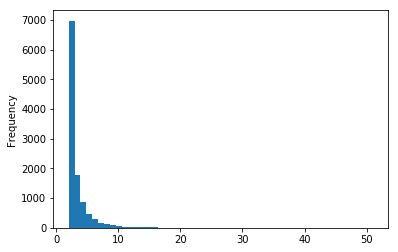

In [39]:
grp['counts'].plot.hist(bins=grp.counts.max())

0b2aa8da3e56c316de348221421cf7c4.jpg
0: *[19gr] HIHI A257  KUAS ROTI BARBEQUE / SILICONE FOOD BRUSH
1466a80ee0a33b7d6651cea5aa5a5be5.jpg
1: [ACQ] Kuas Dapur Silikon / Kuas Kue / Kuas Masak
17e1ba3589880a967fd1bfc05aba650b.jpg
2: [LULU] KUAS SILIKON OLES KUE ROTI / BARBEQUE BBQ / SILICONE BRUSH / OLESAN TELUR MINYAK
2ab4aaf57664eea81143717215cf5430.jpg
3: KUAS SILICONE 17
3872d79d0eac636a41aded9f708a246e.jpg
4: [1KG 100PCS] JOLIECOLLECTIONS KUAS SILIKON OLES KUE ROTI / BARBEQUE BBQ / SILICONE BRUSH
3e3b6fe18e03cc5b701927c41fc5de7a.jpg
5: Kuas Silikon Roti / Cake / Mentega / Food Brush
43022c80da354c9cabdac2c2bac156e2.jpg
6: Kuas Roti Barbeque silikon food brush silicone cake mentega
4cfb1a79fe9514f4f19c7f2569b8b447.jpg
7: NA Kuas Mentega / Kuas Silicon / Kuas Masak
57c19322fc058bb22f74c1542d27da03.jpg
8: BLABLABLA Kuas Roti Bahan Silikon Tahan Panas Silicone Brush Kuas Oles Bumbu Dapur Selai BBQ - KRS
5e7f56dc1969708f58ddc3582058a5f8.jpg
9: [19gr] B08 KUAS ROTI BARBEQUE / SILICONE FOOD 

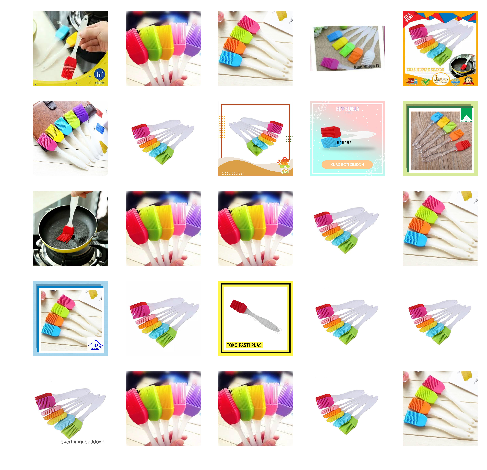

In [59]:
## Example of similar product
product_index = 8
plt.figure(figsize=(8,8))
for i in range(25):
    try:
        img_path = grp.iloc[product_index].images[i]
        plt.subplot(5,5,i+1)
        print(img_path)
        img_path = "../../../shopee-product-matching/train_images/" + img_path
        plt_image(img_path)
        print(f"{i}: {grp.iloc[product_index].titles[i]}" )
    except:
        break

In [9]:
## Text data
train['title_length'] = train.title.map(lambda x: len(x.split()))

Max 61


<AxesSubplot:ylabel='Frequency'>

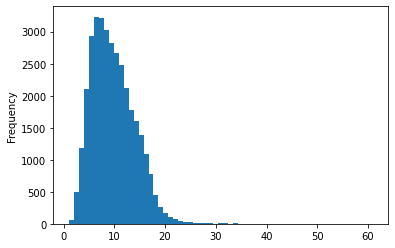

In [10]:
print("Max", train.title_length.max())
train.title_length.plot.hist(bins=train.title_length.max())

In [11]:
long_title = train.sort_values('title_length', ascending=False).title
for t in long_title[0:10]:
    print(t)

Silicone Case Premium Realme 7 7i 5i C15 C12 C17 C11 C2 C3 3 3i 5 6 C1 C3i 5 5S U1 X2 XT Q 6i 2 X2 5 PRO Narzo 20 PRO 10 10A 20A VIVO Y12 Y30 Y15 Y17 Y93 Y95 OPPO A31 2020 A9 A5 2020 A7 A5S A12 Cute Pearl Milk Tea Bear Soft Back Cover PopSocket
Soft Case Silikon Motif Kartun Beruang Warna Permen untuk OPPO A53 2020 Reno 4 A5S A5 2020 A3S A92 A31 A12 A9 2020 F9 PRO A37 A37F F1S F11 A1K F7 A52 A71 F5 Youth A7 A31 A33 2020 A91 Reno 2f Reno 3 A72 A12E Realme C15 C12 5i C11 C2 C3 3 3i 5 5S 6 C1 6i
Soft Case TPU Motif We Bare Bears Lucu dengan PopSocket untuk Realme 7 7i 5i C15 C12 C17 C11 C2 C3 3 3i 5 6 C1 C3i 5 5S U1 X2 XT Q 6i 2 X2 5 PRO Narzo 20 PRO 10 10A 20A VIVO Y12 Y30 Y15 Y17 Y93 Y95 OPPO A31 2020 A9 A5 2020 A7 A5S A12
Case Motif Kartun Beruang Lucu dengan Stand untuk OPPO A53 2020 Reno 4 A5S A5 2020 A3S A92 A31 A12 A9 2020 F9 PRO A37 A37F F1S F11 A1K F7 A52 A71 F5 Youth A7 A31 2020 A91 Reno 2f Reno 3 A72 A12E Realme C15 C12 5i C11 C2 C3 3 3i 5 5S 6 C1 6i Soft Case
Casing Soft Case 